# Example 2: Finding Temporal Relationships

This notebook provides a guide to identifying temporal dependencies. We will show not only the correct solution but also *why* simpler approaches fail, providing a clear illustration of the library's capabilities.

**The Story:**
1.  We'll create a realistic dataset with a known time lag: a lagged random walk.
2.  We'll show that a **naive estimate** (`window_size=1`) completely misses the relationship.
3.  We'll show that a simple **MLP model fails** even with windowing because it cannot process sequences effectively.
4.  Finally, we'll show that the **correct combination** of a `CNN` model and a `ConcatCritic` successfully and efficiently finds the precise time lag.

## 1. Imports and Data Generation

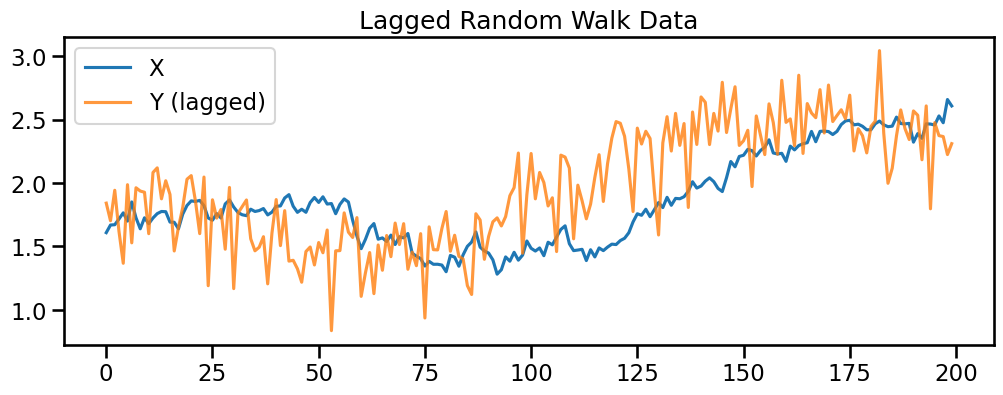

In [1]:
import torch
import numpy as np
import neural_mi as nmi
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

n_samples = 6000
ground_truth_lag = 30

x_raw, y_raw = nmi.datasets.generate_temporally_convolved_data(
    n_samples=n_samples, lag=ground_truth_lag, noise=0.2
)

plt.figure(figsize=(12, 4))
plt.plot(x_raw[0, :200], label='X')
plt.plot(y_raw[0, :200], label='Y (lagged)', alpha=0.8)
plt.title("Lagged Random Walk Data")
plt.legend()
plt.show()

## 2. The Naive Failure: `window_size=1`

First, we prove that looking at single time points is not enough. This will correctly find a smaller MI value.

In [2]:
base_params = {
    'n_epochs': 50, 'learning_rate': 1e-3, 'batch_size': 64,
    'patience': 5, 'embedding_dim': 16, 'hidden_dim': 64, 'n_layers': 2
}

naive_results = nmi.run(
    x_data=x_raw, y_data=y_raw, mode='estimate',
    processor_type='continuous', processor_params={'window_size': 1},
    base_params=base_params, random_seed=42, verbose=False
)

print(f"Naive MI estimate (window_size=1): {naive_results.mi_estimate:.3f} bits")

2025-10-04 13:57:36 - neural_mi - INFO - Starting parameter sweep with 12 workers...


Parameter Sweep Progress:   0%|          | 0/1 [00:00<?, ?task/s]

2025-10-04 13:57:43 - neural_mi - INFO - Parameter sweep finished.
Naive MI estimate (window_size=1): 1.070 bits


## 3. A Better Solution: MLP + Bilinear Critic + Windowing 

An MLP might fail because it flattens the input, destroying the temporal order and then trying to learn it from scratch when we allow a Bilinear Critic to learn all possible combinations of orders. Let's run the sweep to prove that even with a powerful critic, the wrong embedding architecture cannot solve the problem, or at least not clearly.

In [3]:
sweep_grid = {'window_size': [10, 20, 30, 40, 60, 100],
             'run_id': range(5)}

In [4]:
mlp_results = nmi.run(
    x_data=x_raw, y_data=y_raw, mode='sweep',
    critic_type='bilinear', # Use the powerful critic
    processor_type='continuous', processor_params={},
    base_params={**base_params, 'embedding_model': 'mlp'}, # But with the wrong model
    sweep_grid=sweep_grid, n_workers=4, random_seed=42, verbose=False
)

2025-10-04 13:57:44 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-04 13:57:44 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/30 [00:00<?, ?task/s]

2025-10-04 13:58:27 - neural_mi - INFO - Parameter sweep finished.


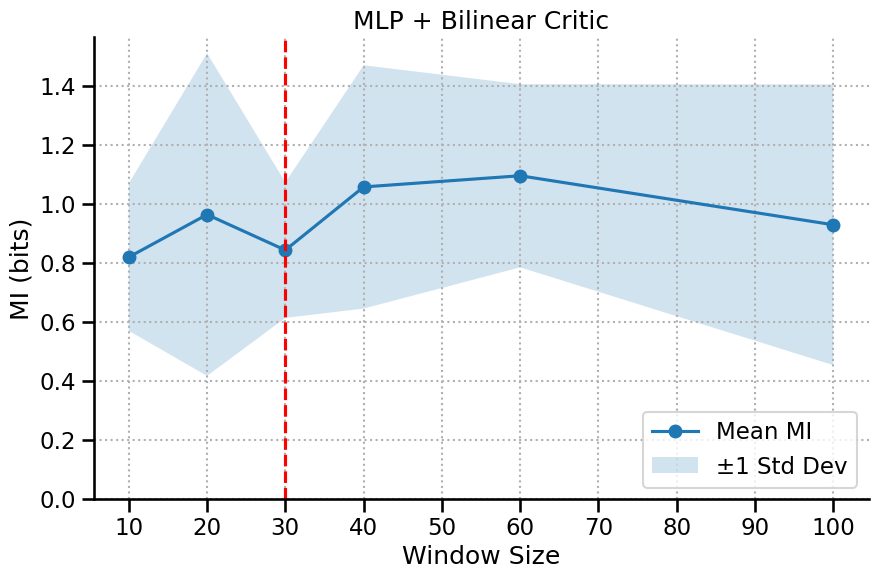

In [5]:
ax = mlp_results.plot(show=False)
ax.set_title("MLP + Bilinear Critic")
ax.axvline(x=ground_truth_lag, color='red', linestyle='--')
ax.set_ylim(bottom=0)
plt.show()

## 4. A Better Solution: CNN + Bilinear Critic

Finally, we use the correct combination: a `CNN` to process the sequences and a `ConcatCritic` to compare them effectively.

In [6]:
base_params_cnn = {
    'embedding_model': 'cnn',
    'n_epochs': 100, 'learning_rate': 3e-4, 'batch_size': 256,
    'patience': 10, 'embedding_dim': 16, 'hidden_dim': 32, 'n_layers': 2
}

cnn_results = nmi.run(
    x_data=x_raw, y_data=y_raw, mode='sweep',
    critic_type='bilinear', 
    processor_type='continuous', processor_params={},
    base_params=base_params_cnn,
    sweep_grid=sweep_grid, n_workers=4, random_seed=42, verbose=False
)

2025-10-04 13:58:27 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-04 13:58:27 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/30 [00:00<?, ?task/s]

2025-10-04 14:01:29 - neural_mi - INFO - Parameter sweep finished.


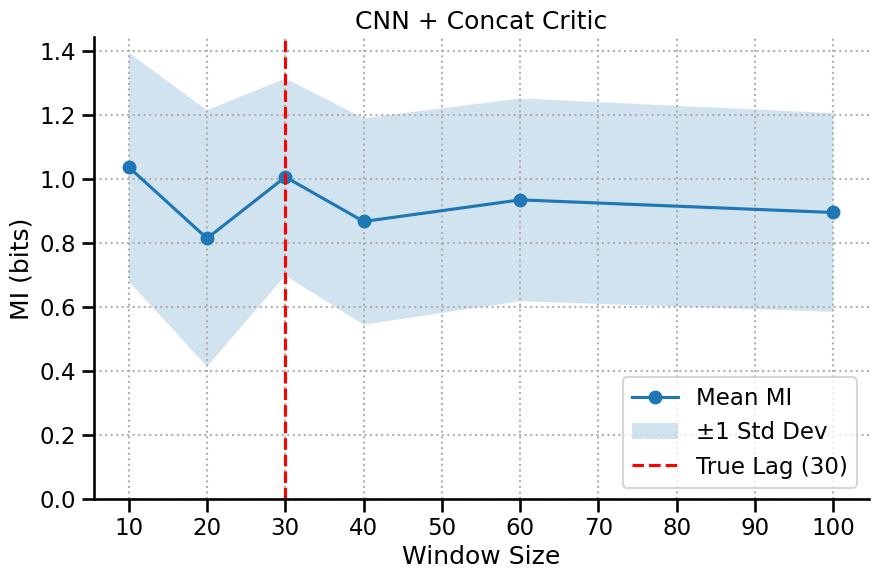

--- Best Result ---
Optimal Window Size: 10.0
Maximum MI Estimated: 1.038 bits


In [7]:
ax = cnn_results.plot(show=False)
ax.set_title("CNN + Concat Critic")
ax.axvline(x=ground_truth_lag, color='red', linestyle='--', label=f'True Lag ({ground_truth_lag})')
ax.set_ylim(bottom=0)
ax.legend()
plt.show()

best_run = cnn_results.dataframe.loc[cnn_results.dataframe['mi_mean'].idxmax()]
print(f"--- Best Result ---\nOptimal Window Size: {best_run['window_size']}\nMaximum MI Estimated: {best_run['mi_mean']:.3f} bits")